In [16]:
#Importing what we'll need

#Basic Needs
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#For creating our model
import tensorflow as tf
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator

#Pre-Trained model
from keras.applications import EfficientNetB0

In [17]:
#Checking our dataset
print(os.listdir("archive"))

['anno_test.csv', 'names.csv', 'anno_train.csv', 'car_data']


In [18]:
train_df = pd.read_csv("archive/anno_train.csv")
test_df = pd.read_csv("archive/anno_test.csv")
names_df = pd.read_csv("archive/names.csv")

In [19]:
train_df.shape

(8143, 6)

In [20]:
test_df.shape

(8040, 6)

In [21]:
names_df.shape

(195, 1)

In [22]:
train_df.head()

,00001.jpg,39,116,569,375,14
0,00002.jpg,36,116,868,587,3
1,00003.jpg,85,109,601,381,91
2,00004.jpg,621,393,1484,1096,134
3,00005.jpg,14,36,133,99,106
4,00006.jpg,259,289,515,416,123


In [23]:
test_df.head()

,00001.jpg,30,52,246,147,181
0,00002.jpg,100,19,576,203,103
1,00003.jpg,51,105,968,659,145
2,00004.jpg,67,84,581,407,187
3,00005.jpg,140,151,593,339,185
4,00006.jpg,20,77,420,301,78


In [24]:
train_df.isna().sum().any()

False

In [25]:
test_df.isna().sum().any()

False

In [26]:
names_df.isna().sum().any()

False

In [27]:
#Looks good, time to start creating our model
#Firstly, let's code our variables so when we finish if we are not happy with the results but our coding has no problem
#we can just come here and make changes, makes our job really easier
BATCH = 32
IMAGE_SIZE = 224
EPOCHS = 3
LEARNING_RATE = 0.03

In [28]:
#Now, let's have variations of our datas for lowering overfitting
train_dir = "archive/car_data/car_data/train/"
test_dir = "archive/car_data/car_data/test/"
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    zoom_range = 0.2,
    shear_range = 0.2,
    fill_mode='nearest',
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size = BATCH,
                                                    class_mode = "categorical"
)
validation_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                        batch_size = BATCH,
                                                        class_mode = "categorical"
)

Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [29]:
#Calling our pre-trained model and making it untrainable, we will only train out classifier which is our Dense layer
pt_model = EfficientNetB0(weights="imagenet", include_top = False)
pt_model.trainable = False

#Creating our model
model = tf.keras.Sequential([
    pt_model,
    GlobalAveragePooling2D(),
    Dense(196, activation = "softmax")
])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 196)               251076    
                                                                 
Total params: 4,300,647
Trainable params: 251,076
Non-trainable params: 4,049,571
_________________________________________________________________


In [30]:
#Everything is ready, time to train our model
history = model.fit_generator(train_generator,
                              validation_data = validation_generator,
                              epochs = EPOCHS,
                              verbose = 1
)

/tmp/ipykernel_5081/3511729836.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/3
255/255 [==============================] - 2310s 9s/step - loss: 10.4320 - accuracy: 0.0042 - val_loss: 8.5315 - val_accuracy: 0.0047
Epoch 2/3
255/255 [==============================] - 2238s 9s/step - loss: 9.2536 - accuracy: 0.0050 - val_loss: 9.4036 - val_accuracy: 0.0055
Epoch 3/3
255/255 [==============================] - 2160s 8s/step - loss: 9.4744 - accuracy: 0.0049 - val_loss: 9.1159 - val_accuracy: 0.0051


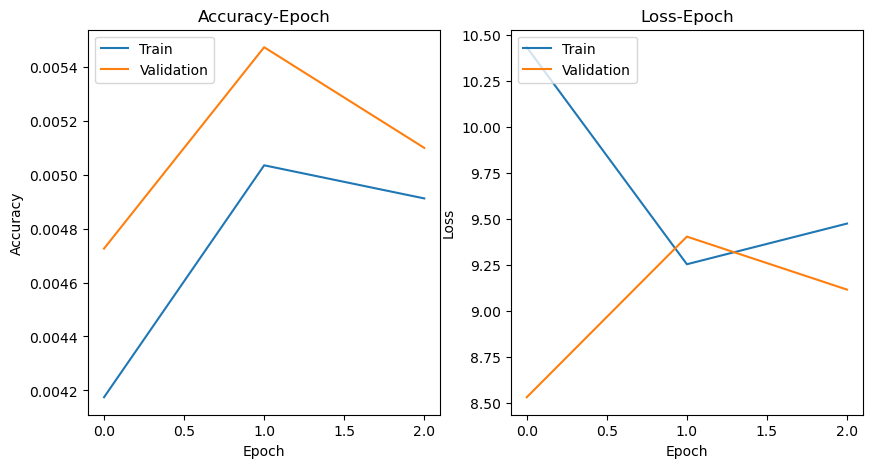

In [45]:
#Finally, we can see how great our model did with matplotlib

#Graph of our accuracy
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy-Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")

#Graph of our loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss-Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")

plt.show()